# Figure S13

Temperature anomalies in the Amundsen Sea

In [1]:
import numpy as np
import xarray as xr
from glob import glob
import gsw
import cosima_cookbook as cc

import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib as mpl


import cartopy.crs as ccrs
import cmocean.cm as cmo

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43307/status,
Dashboard: /proxy/43307/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33703,Workers: 7
Dashboard: /proxy/43307/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:41949,Total threads: 4
Dashboard: /proxy/39839/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:36925,


In [3]:
import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

Miscellaneous plotting data. 

In [4]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
ctrl = '01deg_jra55v13_ryf9091'

# topography data for plotting:
ht = cc.querying.getvar(ctrl,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

Define experiments and databases

In [5]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbation experiments
expt_session =cc.database.create_session('/g/data/e14/hd4873/access-om2-01/project03_misc_data/databases/SSP2100_experiments_nodaily.db')
expt_ssp245 = '01deg_jra55v13_ryf9091_ssp245'
expt_ssp245mw = '01deg_jra55v13_ryf9091_ssp245_mw'
expt_ssp245mw_high = '01deg_jra55v13_ssp245_windthermalmw_high'
expt_ssp585 = '01deg_jra55v13_ryf9091_ssp585'
expt_ssp585mw = '01deg_jra55v13_ryf9091_ssp585_mw'

In [6]:
def read_data(start_time, end_time, expt, session):
    print(expt)
    lat_slice  = slice(-80,-64)
    lon_slice = slice(-115, -95)
    z_slice = slice(0, 2000)
    
    variables = ['temp', 'salt']
  
    temp = cc.querying.getvar(expt,variables[0],session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp = temp.sel(yt_ocean=lat_slice, xt_ocean=lon_slice, st_ocean=z_slice).sel(time=slice(start_time,end_time)).load() 

    salt = cc.querying.getvar(expt,variables[1],session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    salt = salt.sel(yt_ocean=lat_slice, xt_ocean=lon_slice, st_ocean=z_slice).sel(time=slice(start_time,end_time)).load() 
    
    # call function to convert salt from psu to absolute salinity
    salt = convert_salt(salt)

    sig1 = calc_sigma1(temp, salt).compute()
    sig0 = calc_sigma0(temp, salt).compute()

    return temp, salt, sig1, sig0

def convert_salt(salt):
    import gsw
    # convert salinity (psu) to absolute salinity using gsw toolbox
    p = gsw.p_from_z(-salt.st_ocean, salt.yt_ocean)
    salt_sa = gsw.SA_from_SP(salt, p, salt.xt_ocean, salt.yt_ocean)
    return salt_sa

def calc_sigma1(temp, salt):
    sig1 = gsw.density.sigma1(salt, temp)
    return sig1

def calc_sigma0(temp, salt):
    sig0 = gsw.density.sigma0(salt, temp)
    return sig0

def plot_land_mask(axes):
     for i, ax in enumerate(axes.flatten()):
         ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500, 1000,3000],colors=['w','k','grey'],linewidths=1,)
         ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,)
         ax.set_ylim([-79,-60])
         if i > 0:
            ax.set_yticklabels([])

def colorbar_vert(cb, axes, label):
    fs = 16
    cbaxes = fig.add_axes(axes)
    cbar = plt.colorbar(cb, cax = cbaxes, orientation = 'vertical',extend = 'both')
    cbar.set_label(label,fontsize=fs,labelpad=6)
    #cbar.ax.tick_params(labelsize=fs, labeltop=True)
    return cbar

In [7]:
from palettable.cmocean.diverging import Balance_9
from palettable.cmocean.sequential import Thermal_20

cmap = plt.cm.get_cmap(Balance_9.mpl_colormap)
levels = np.arange(-1.5, 1.6, 0.1)

cmap2 = plt.cm.get_cmap(Thermal_20.mpl_colormap)
levels2 = np.arange(-2, 3.2, 0.2)

In [8]:
%%time
start_time = '2160-01-01'
end_time = '2164-12-31'
#control
temp_ctrl, salt_ctrl, sig1_ctrl, sig0_ctrl = read_data(start_time, end_time, control, master_session)

# experiments
temp_ssp245, salt_ssp245, sig1_ssp245, sig0_ssp245 = read_data(start_time, end_time, expt_ssp245, expt_session)
temp_ssp245mw, salt_ssp245mw, sig1_ssp245mw, sig0_ssp245mw = read_data(start_time, end_time, expt_ssp245mw, expt_session)
temp_ssp585, salt_ssp585, sig1_ssp585, sig0_ssp585 = read_data(start_time, end_time, expt_ssp585, expt_session)
temp_ssp585mw, salt_ssp585mw, sig1_ssp585mw, sig0_ssp585mw = read_data(start_time, end_time, expt_ssp585mw, expt_session)

01deg_jra55v13_ryf9091


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

01deg_jra55v13_ryf9091_ssp245


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

01deg_jra55v13_ryf9091_ssp245_mw


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

01deg_jra55v13_ryf9091_ssp585


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

01deg_jra55v13_ryf9091_ssp585_mw


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

CPU times: user 3min 16s, sys: 32.9 s, total: 3min 49s
Wall time: 4min 3s


Read in cell thickness variable

In [9]:
lat_slice  = slice(-80,-64)
lon_slice = slice(-115, -95)
z_slice = slice(0, 2000)

dzt = cc.querying.getvar(ctrl, 'dzt', master_session, start_time = '2160-01-01', end_time = '2164-12-31')
dzt = dzt.sel(yt_ocean=lat_slice, xt_ocean=lon_slice, st_ocean=z_slice).sel(time=slice(start_time,end_time)).load() 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

Calculate depth-weighted mean temperatures


In [10]:
zt, zb = 70, 350
z_slice = slice(zt, zb)
dzt_sum = dzt.sel(st_ocean=z_slice).sum('st_ocean')


anom_ssp245 = (((temp_ssp245 - temp_ctrl) * dzt).sel(st_ocean=z_slice) / dzt_sum).sum('st_ocean').mean(dim='time')
anom_ssp245mw = (((temp_ssp245mw - temp_ctrl) * dzt).sel(st_ocean=z_slice) / dzt_sum).sum('st_ocean').mean(dim='time')
anom_ssp585 = (((temp_ssp585 - temp_ctrl) * dzt).sel(st_ocean=z_slice) / dzt_sum).sum('st_ocean').mean(dim='time')
anom_ssp585mw = (((temp_ssp585mw - temp_ctrl) * dzt).sel(st_ocean=z_slice) / dzt_sum).sum('st_ocean').mean(dim='time')

Plot figure

In [ ]:
vmin, vmax = -1.5,1.5
labels = ['SSP245','SSP245-MW','SSP585','SSP585-MW']
subplot_labels = ['A','B','C','D']

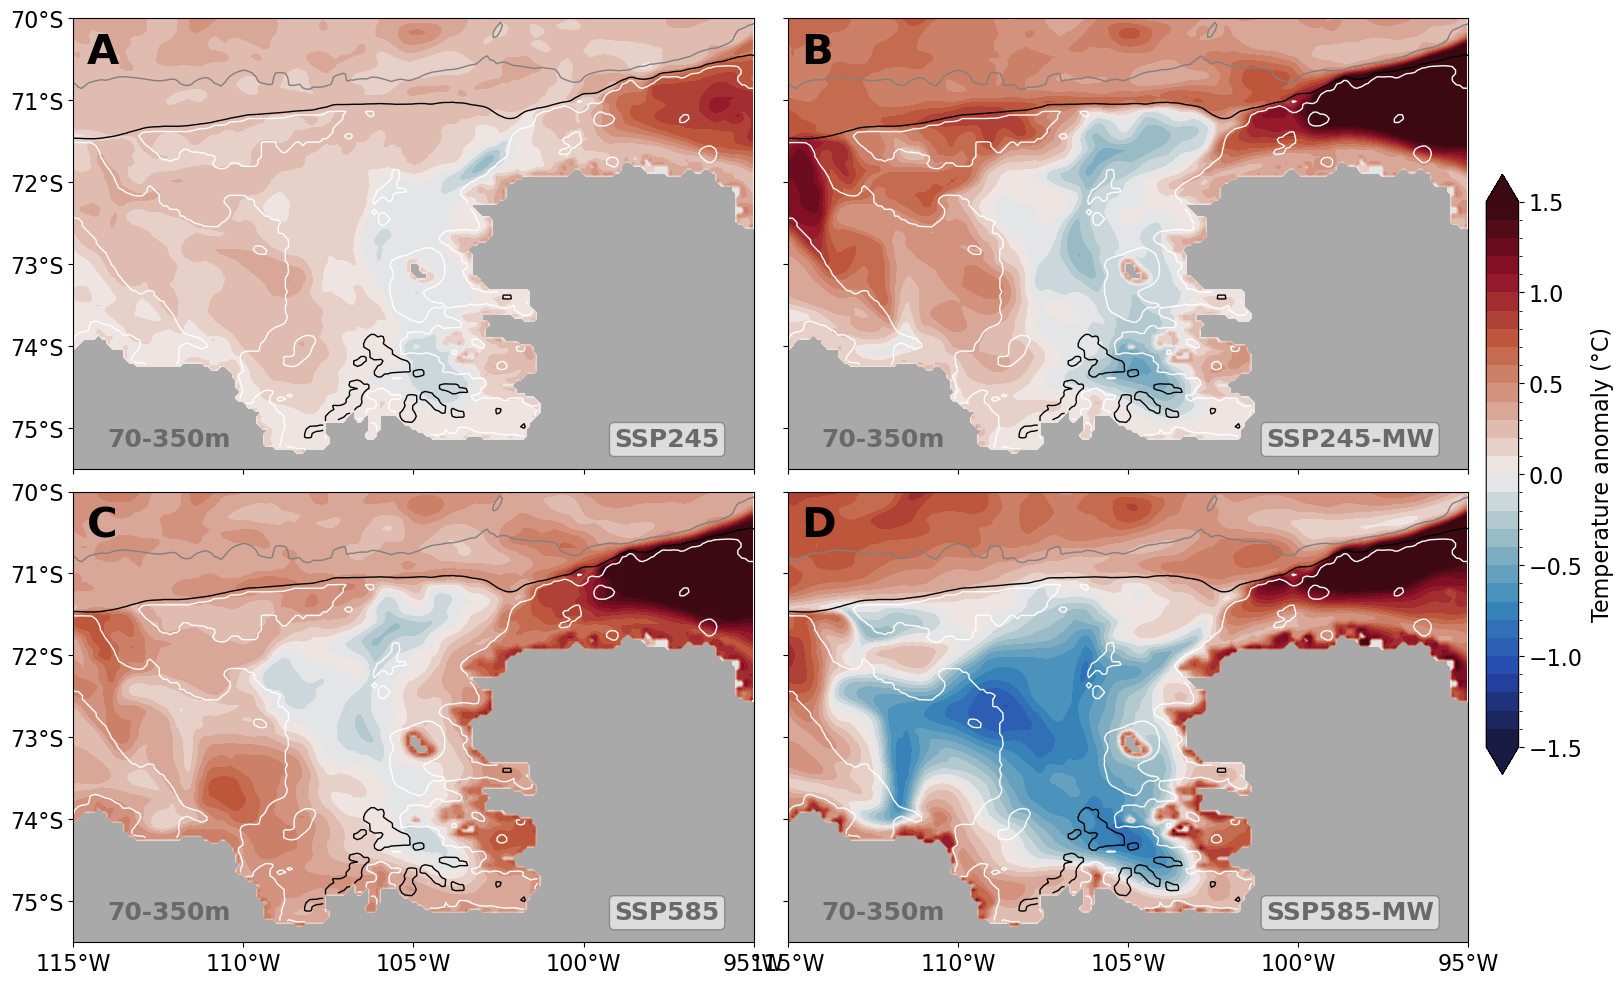

In [11]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

plot_land_mask(axes.flatten())

for i, ax in enumerate(axes.flatten()):
    ax.text(0.02, 0.9, f'{subplot_labels[i]}',  c='k', fontsize=30, fontweight='bold', transform = ax.transAxes)
    ax.text(0.05, 0.05, f'{zt}-{zb}m',  c='dimgrey', fontsize=18, fontweight='bold', transform=ax.transAxes)
    ax.text(0.95, 0.05, f'{labels[i]}', fontsize=18, fontweight='bold', color='dimgrey', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='w', alpha=0.6, edgecolor='dimgrey', boxstyle='round,pad=0.2'))


cb = axes[0,0].contourf(temp_ssp245.xt_ocean, temp_ssp245.yt_ocean, anom_ssp245,
                        cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                        levels=levels, extend='both')
axes[0,1].contourf(temp_ssp245mw.xt_ocean, temp_ssp245mw.yt_ocean, anom_ssp245mw,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,0].contourf(temp_ssp585.xt_ocean, temp_ssp585.yt_ocean, anom_ssp585,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')
axes[1,1].contourf(temp_ssp585mw.xt_ocean, temp_ssp585mw.yt_ocean, anom_ssp585mw,
                   cmap=cmap, norm=mpl.colors.BoundaryNorm(levels,ncolors=cmap.N, clip=False), 
                   levels=levels, extend='both')


axes[0,0].set_xlim(-115,-95)
axes[0,0].set_ylim(-75.5,-70)
axes[0,0].set_yticks([-75,-74,-73,-72,-71,-70])
axes[0,0].set_yticklabels(['75\u00b0S','74\u00b0S','73\u00b0S','72\u00b0S','71\u00b0S','70\u00b0S'])
axes[0,0].set_xticks([-115,-110,-105,-100,-95])
axes[0,0].set_xticklabels(['115\u00b0W','110\u00b0W','105\u00b0W','100\u00b0W','95\u00b0W'])

cbar = colorbar_vert(cb, [0.91, 0.25, 0.018, 0.5], 'Temperature anomaly (\u00b0C)')
cbar.ax.set_yticks([-1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5])

# save to file
save_flag = 0
figfile = f'../figs/SuppFig_AmundsenSea_cooling_maps.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)


plt.show()